In [1]:
!pip install torch==2.0.1 transformers==4.32.1 sympy==1.10.1
!pip install pandas matplotlib seaborn
!pip install scipy
!pip install numpy==1.24.4


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import json

/Users/ethanarnn/anaconda3/envs/roberta-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

/Users/ethanarnn/anaconda3/envs/roberta-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/ethanarnn/anaconda3/envs/roberta-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def tweet_sentiment(tweet):

    encoded_tweet = tokenizer(tweet, return_tensors='pt')

    output = model(**encoded_tweet)

    scores = softmax(output[0][0].detach().numpy())

    return scores


def max_depth(tweet_data):
        stack = []

        max_length = 0

        for tweet in tweet_data['comments']:
                stack.append((tweet, 1))

        while stack:
                tweet, layer = stack.pop()
                if len(tweet['replies']) == 0: # raeched the end
                        max_length = max(layer, max_length)
                else:
                        for new_tweet in tweet['replies']:
                                stack.append((new_tweet, layer + 1))

        return max_length


def fan_sentiment(tweet_data):
       total_score, total_weight = traverse_comments(tweet_data['comments'], 1)
       if total_weight == 0:
              return
       return total_score / total_weight

#find longest chain, count num of posts that have 2 or more direct replies, add neutral and negative

In [172]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

# fan_sentiment(tweet_data)
tweet_data['comments']

[{'author_name': 'Agent 1',
  'personality': {'Sarcastic': 0.12,
   'Anger': -0.85,
   'Neuroticism': 0.25,
   'Toxcitiy': -0.12,
   'Obsession': 0.3,
   'Elitism': 0,
   'Sycophantic': 0.4,
   'Loyalty': 0.9,
   'Apathy': 0.0},
  'message_id': '1_1',
  'comment_text': "She's literally the best songwriter of our generation. Period.",
  'replies': [{'author_name': 'Agent 2',
    'personality': {'Sarcastic': 0.12,
     'Anger': -0.85,
     'Neuroticism': 0.25,
     'Toxcitiy': -0.12,
     'Obsession': 0.3,
     'Elitism': 0,
     'Sycophantic': 0.4,
     'Loyalty': 0.9,
     'Apathy': 0.0},
    'message_id': '2_1',
    'comment_text': 'More like the most overrated. Her lyrics are just high school poetry.',
    'replies': [{'author_name': 'Agent 3',
      'personality': {'Sarcastic': 0.12,
       'Anger': -0.85,
       'Neuroticism': 0.25,
       'Toxcitiy': -0.12,
       'Obsession': 0.3,
       'Elitism': 0,
       'Sycophantic': 0.4,
       'Loyalty': 0.9,
       'Apathy': 0.0},
      

In [13]:
from collections import deque

In [32]:
queue = deque()

max_length = 0

for tweet in tweet_data['comments']:
    queue.appendleft((tweet, 1))

while queue:
    tweet, layer = queue.pop()
    if len(tweet['replies']) == 0: # raeched the end
        max_length = max(layer, max_length)
    else:
        for new_tweet in tweet['replies']:
            queue.appendleft((new_tweet, layer + 1))

print(f'The deepest layer is {layer}.')

The deepest layer is 3.


In [66]:
tweet_data

{'name': 'Agent 47',
 'personality': {'Sarcastic': 0.12,
  'Anger': -0.85,
  'Neuroticism': 0.25,
  'Toxcitiy': -0.12,
  'Obsession': 0.3,
  'Elitism': 0,
  'Sycophantic': 0.4,
  'Loyalty': 0.9,
  'Apathy': 0.0},
 'post_text': 'Taylor Swift continues to be one of the most polarizing artists of our time. Some call her a lyrical genius, others... not so much.',
 'message_id': 'MAIN',
 'comments': []}

In [68]:
stack = tweet_data['comments']
visited = set()
responses = []
while stack:
    tweet = stack.pop()
    visited.add(tweet['message_id'])
    responses.append(tweet['comment_text'])
    for new_tweet in tweet['replies']:
        if new_tweet['message_id'] not in visited:
            stack.append(new_tweet)

print(len(visited))

12


In [69]:
responses

["I don't love her or hate her, but you all need to chill 😂",
 "Y'all really acting like she invented music. Calm down.",
 "Nobody said that. We're just vibing, let us live.",
 "Your feed is full of Swift because she's relevant and you're obsessed. 😘",
 'Vibe somewhere else. My feed is full of Swift right now.',
 'Whether you like her or not, her ability to reinvent herself is impressive.',
 "Or maybe it's just marketing gimmicks lol.",
 "Tell me you don't understand artistic evolution without telling me.",
 "She's literally the best songwriter of our generation. Period.",
 'More like the most overrated. Her lyrics are just high school poetry.',
 'Go back to your metal cave and leave us in peace.',
 "You clearly haven't listened to All Too Well (10 Minute Version)."]

In [70]:
import matplotlib.pyplot as plt

In [73]:
print("negative", "neutral", "positive")
senti = []
for resp in responses:
    senti.append(tweet_sentiment(resp))

negative neutral positive


In [74]:
senti

[array([0.35311177, 0.535969  , 0.11091916], dtype=float32),
 array([0.6204534 , 0.33567846, 0.04386818], dtype=float32),
 array([0.04034606, 0.5758512 , 0.38380265], dtype=float32),
 array([0.02518899, 0.22029097, 0.75452   ], dtype=float32),
 array([0.40944174, 0.48054302, 0.11001521], dtype=float32),
 array([0.00429474, 0.08969887, 0.9060064 ], dtype=float32),
 array([0.30174777, 0.6246345 , 0.07361767], dtype=float32),
 array([0.65573305, 0.33089852, 0.01336838], dtype=float32),
 array([0.00200974, 0.0146739 , 0.98331636], dtype=float32),
 array([0.90713006, 0.08237939, 0.01049064], dtype=float32),
 array([0.41168505, 0.515554  , 0.07276095], dtype=float32),
 array([0.6003084 , 0.36756298, 0.0321286 ], dtype=float32)]

(array([25.,  7.,  2.,  1.,  6.,  2.,  5.,  2.,  4.,  4.]),
 array([0.01394084, 0.1111935 , 0.20844616, 0.30569881, 0.40295148,
        0.50020415, 0.59745681, 0.69470942, 0.79196209, 0.88921475,
        0.98646742]),
 <BarContainer object of 10 artists>)

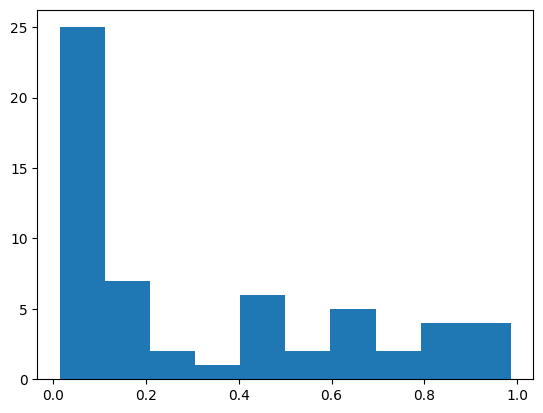

In [88]:
plt.hist(x = [tup[2] for tup in senti])

In [129]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

In [83]:
stack = tweet_data['comments']
visited = set()
responses = []
while stack:
    tweet = stack.pop()
    visited.add(tweet['message_id'])
    responses.append(tweet['comment_text'])
    if 'replies' not in tweet.keys():
        continue
    for new_tweet in tweet['replies']:
        if new_tweet['message_id'] not in visited:
            stack.append(new_tweet)

print(len(visited))

58


In [81]:
tweet_data.keys()

dict_keys(['post_text', 'name', 'personality', 'message_id', 'comments'])

In [84]:
print("negative", "neutral", "positive")
senti = []
text = []
for resp in responses:
    text.append(resp)
    senti.append(tweet_sentiment(resp))

negative neutral positive


In [85]:
text


["This ain't it, chief.",
 "Care to elaborate, or is that all you've got?",
 "No point arguing, you've made up your mind anyway.",
 "Finally someone said it. I thought I was the only one who doesn't worship her.",
 'Oh look, the haters are gathering 🙃.',
 'I suspect a lot of the "overrated" comments she gets are because her core fanbase is young women. Sadly, anything popular with young women (boy bands, pop stars, etc.) tends to get unfairly trashed as less legitimate. If a dude in a rock band writes about relationships, he\'s "deep", but if Taylor does it, she\'s "whiny" or whatever. There\'s definitely a double standard in how people judge her and her fans.',
 "Or, hear me out: some people just don't like her music. Not everything is about sexism or whatever. I get your point, but sometimes an overrated pop star is just an overrated pop star, regardless of who likes them.",
 'Sure, personal taste plays a role. But it\'s worth noticing how often "stuff teenage girls like" gets labele

In [114]:
for index, value in enumerate(senti):
    if value[2] > 0.96 and value[2] < 0.9999:
        print(text[index], value[2])
        break

Yo, OP, Imma let you finish, but Beyoncé had one of the best videos of all time! *Of all time!* 😏 0.9864674


In [111]:
max([s[2] for s in senti])

0.9864674

In [120]:
plus, minus, zero = 0, 0, 0

for neg, neu, pos in senti:
    if neg > 0.69:
        minus += 1
    elif pos > 0.69:
        plus += 1
    else:
        zero += 1

In [121]:
print(minus, zero, plus)

9 39 10


In [ ]:
def calculate_polarity(tweet_data):
    stack = tweet_data['comments']
    visited = set()
    responses = []
    while stack:
        tweet = stack.pop()
        visited.add(tweet['message_id'])
        responses.append(tweet['comment_text'])
        if 'replies' not in tweet.keys():
            continue
        for new_tweet in tweet['replies']:
            if new_tweet['message_id'] not in visited:
                stack.append(new_tweet)

    senti = []
    text = []
    for resp in responses:
        text.append(resp)
        senti.append(tweet_sentiment(resp))
    
    plus, minus, zero = 0, 0, 0

    for neg, neu, pos in senti:
        if neg > 0.69:
            minus += 1
        elif pos > 0.69:
            plus += 1
        else:
            zero += 1
    
    return ((minus + plus) / max(zero, 0.001)) * (plus + minus + zero)
    


In [ ]:
def calculate_polarity(tweet_data):
    stack = tweet_data['comments']
    visited = set()
    responses = []
    while stack:
        tweet = stack.pop()
        visited.add(tweet['message_id'])
        responses.append(tweet['comment_text'])
        if 'replies' not in tweet.keys():
            continue
        for new_tweet in tweet['replies']:
            if new_tweet['message_id'] not in visited:
                stack.append(new_tweet)

    senti = []
    text = []
    for resp in responses:
        text.append(resp)
        senti.append(tweet_sentiment(resp))
    
    plus, minus, zero = 0, 0, 0

    for neg, neu, pos in senti:
        if neg > 0.69:
            minus += 1
        elif pos > 0.69:
            plus += 1
        else:
            zero += 1
    
    return ((minus + plus) / max(zero, 0.001)) * (plus + minus + zero)
    


In [ ]:
def make_agent(name, personality, sentiment, sign):
    return {
        "name" : name,
        "personality" : personality,
        "sentiment" : sentiment,
        "sign": sign
    }


In [ ]:
def calculate_parallel(tweet_data):
    # formatting
    return_template = { # agent 1, agent 2, ... 
        "agents": [

        ]
    }
    agent_personalities = {}
    agent_sentiments = {} # agent 47 : [0.84, 0.99, 0.75]
    agent_sign = {} # agent 47 : [pos, neg, neu]

    stack = tweet_data['comments']
    visited = set()
    responses = []
    while stack:
        # examining current tweet
        tweet = stack.pop()
        visited.add(tweet['message_id'])

        # processing tweet
        author = tweet['author_name']
        if agent_personalities.get(author, None) == None: # note: need to standardize
            agent_personalities[author] = tweet['personality']

        neg, neu, pos = tweet_sentiment(tweet['comment_text'])

        if neg > neu and neg > pos: # neg
            agent_sign[author] = agent_sign.get(author, []) + ["negative"]
        elif pos > neu and pos > neg: # pos
            agent_sign[author] = agent_sign.get(author, []) + ["positive"]
        else:
            agent_sign[author] = agent_sign.get(author, []) + ["neutral"]
        
        agent_sentiments[author] = max(neg, neu, pos)


        # finding new tweets
        if 'replies' not in tweet.keys():
            continue
        for new_tweet in tweet['replies']:
            if new_tweet['message_id'] not in visited:
                stack.append(new_tweet)
    
    for author in agent_personalities.keys():
        return_template['agents'].append(make_agent(author, agent_personalities[author], agent_sentiments[author], agent_sign[author]))

    #schema = json.dump(return_template)
    # return schema
    return return_template
    

In [184]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

In [139]:
schema = calculate_parallel(tweet_data)

In [140]:
type(schema)

dict

In [144]:
schema['agents'][7]

{'name': 'Agent 1',
 'personality': {'Sarcastic': 0.12,
  'Anger': -0.85,
  'Neuroticism': 0.25,
  'Toxcitiy': -0.12,
  'Obsession': 0.3,
  'Elitism': 0,
  'Sycophantic': 0.4,
  'Loyalty': 0.9,
  'Apathy': 0.0},
 'sentiment': 0.98331636,
 'sign': ['positive']}

In [153]:
def calculate_pi(tweet_data, temp=0.69):
    stack = tweet_data['comments']
    visited = set()
    responses = []
    while stack:
        tweet = stack.pop()
        visited.add(tweet['message_id'])
        responses.append(tweet['comment_text'])
        for new_tweet in tweet['replies']:
            if new_tweet['message_id'] not in visited:
                stack.append(new_tweet)
    senti = []
    for resp in responses:
        senti.append(tweet_sentiment(resp))
    
    plus, minus, zero = 0, 0, 0

    for neg, neu, pos in senti:
        if neg > temp:
            minus += 1
        elif pos > temp:
            plus += 1
        else:
            zero += 1
        
    schema = {
        "sentiment_counts": {
            "positive" : plus,
            "negative" : minus,
            "neutral" : zero
        }
    }

    return schema
        
    
    
    

In [154]:
calculate_pi(tweet_data)

{'sentiment_counts': {'positive': 0, 'negative': 0, 'neutral': 0}}

In [155]:
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from collections import Counter
import nltk

ModuleNotFoundError: No module named 'nltk'

In [158]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
print("Sample stop words:", list(stop_words)[:10])


Sample stop words: ["you've", 'over', 'off', 'with', 'each', 'before', 'where', 'do', 'in', 'again']


In [198]:
from transformers import AutoTokenizer
from nltk.corpus import stopwords
import nltk
import json
import re

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
stop_words = set(stopwords.words("english"))

def get_word_frequencies_json(sentences):
    word_freq = {}

    for sentence in sentences:
        # Tokenize into input IDs
        input_ids = tokenizer.encode(sentence, add_special_tokens=False)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        word = ""
        for token in tokens:
            if token.startswith("##"):
                word += token[2:]  # Continue the subword
            else:
                if word:  # Add the previous word if exists
                    word_lower = word.lower()
                    if word_lower not in stop_words and word_lower.isalpha():
                        word_freq[word_lower] = word_freq.get(word_lower, 0) + 1
                word = token  # Start a new word

        # Catch the last word
        if word:
            word_lower = word.lower()
            if word_lower not in stop_words and word_lower.isalpha():
                word_freq[word_lower] = word_freq.get(word_lower, 0) + 1

    # Convert to JSON format
    word_frequencies = [{"text": word, "value": count} for word, count in word_freq.items()]
    # return json.dumps({"word_frequencies": word_frequencies}, indent=2)
    return {"word_frequencies": word_frequencies}



In [207]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

In [200]:
def calculate_cloud(tweet_data, temp=0.69):
    stack = tweet_data['comments']
    visited = set()
    responses = []
    while stack:
        tweet = stack.pop()
        visited.add(tweet['message_id'])
        responses.append(tweet['comment_text'])
        for new_tweet in tweet['replies']:
            if new_tweet['message_id'] not in visited:
                stack.append(new_tweet)

    return get_word_frequencies_json(responses)

In [208]:
word_cloud = calculate_cloud(tweet_data)

#write to json file
with open('several-ducks-datahacks25/agents/word_cloud_ex.json', 'w') as f:
    json.dump(word_cloud, f, indent=4)

In [ ]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

calculate_parallel(tweet_data)

{'agents': [{'name': 'Agent 11',
   'personality': {'Sarcastic': 0.12,
    'Anger': -0.85,
    'Neuroticism': 0.25,
    'Toxcitiy': -0.12,
    'Obsession': 0.3,
    'Elitism': 0,
    'Sycophantic': 0.4,
    'Loyalty': 0.9,
    'Apathy': 0.0},
   'sentiment': 0.6060652,
   'sign': ['neutral']},
  {'name': 'Agent 8',
   'personality': {'Sarcastic': 0.12,
    'Anger': -0.85,
    'Neuroticism': 0.25,
    'Toxcitiy': -0.12,
    'Obsession': 0.3,
    'Elitism': 0,
    'Sycophantic': 0.4,
    'Loyalty': 0.9,
    'Apathy': 0.0},
   'sentiment': 0.88908476,
   'sign': ['neutral', 'neutral']},
  {'name': 'Agent 9',
   'personality': {'Sarcastic': 0.12,
    'Anger': -0.85,
    'Neuroticism': 0.25,
    'Toxcitiy': -0.12,
    'Obsession': 0.3,
    'Elitism': 0,
    'Sycophantic': 0.4,
    'Loyalty': 0.9,
    'Apathy': 0.0},
   'sentiment': 0.85243106,
   'sign': ['neutral']},
  {'name': 'Agent 10',
   'personality': {'Sarcastic': 0.12,
    'Anger': -0.85,
    'Neuroticism': 0.25,
    'Toxcitiy': -0

In [215]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

calculate_pi(tweet_data)

{'word_frequencies': [{'text': 'love', 'value': 1},
  {'text': 'hate', 'value': 1},
  {'text': 'need', 'value': 1},
  {'text': 'chill', 'value': 1},
  {'text': 'really', 'value': 1},
  {'text': 'acting', 'value': 1},
  {'text': 'like', 'value': 3},
  {'text': 'invented', 'value': 1},
  {'text': 'music', 'value': 1},
  {'text': 'calm', 'value': 1},
  {'text': 'nobody', 'value': 1},
  {'text': 'said', 'value': 1},
  {'text': 'vibing', 'value': 1},
  {'text': 'let', 'value': 1},
  {'text': 'us', 'value': 2},
  {'text': 'live', 'value': 1},
  {'text': 'feed', 'value': 2},
  {'text': 'full', 'value': 2},
  {'text': 'swift', 'value': 2},
  {'text': 'relevant', 'value': 1},
  {'text': 'obsessed', 'value': 1},
  {'text': 'vibe', 'value': 1},
  {'text': 'somewhere', 'value': 1},
  {'text': 'else', 'value': 1},
  {'text': 'right', 'value': 1},
  {'text': 'whether', 'value': 1},
  {'text': 'ability', 'value': 1},
  {'text': 'reinvent', 'value': 1},
  {'text': 'impressive', 'value': 1},
  {'text':

In [216]:
with open('several-ducks-datahacks25/agents/sample_msg.json', 'r') as f:
        tweet_data = json.load(f)

calculate_cloud(tweet_data)

{'word_frequencies': [{'text': 'love', 'value': 1},
  {'text': 'hate', 'value': 1},
  {'text': 'need', 'value': 1},
  {'text': 'chill', 'value': 1},
  {'text': 'really', 'value': 1},
  {'text': 'acting', 'value': 1},
  {'text': 'like', 'value': 3},
  {'text': 'invented', 'value': 1},
  {'text': 'music', 'value': 1},
  {'text': 'calm', 'value': 1},
  {'text': 'nobody', 'value': 1},
  {'text': 'said', 'value': 1},
  {'text': 'vibing', 'value': 1},
  {'text': 'let', 'value': 1},
  {'text': 'us', 'value': 2},
  {'text': 'live', 'value': 1},
  {'text': 'feed', 'value': 2},
  {'text': 'full', 'value': 2},
  {'text': 'swift', 'value': 2},
  {'text': 'relevant', 'value': 1},
  {'text': 'obsessed', 'value': 1},
  {'text': 'vibe', 'value': 1},
  {'text': 'somewhere', 'value': 1},
  {'text': 'else', 'value': 1},
  {'text': 'right', 'value': 1},
  {'text': 'whether', 'value': 1},
  {'text': 'ability', 'value': 1},
  {'text': 'reinvent', 'value': 1},
  {'text': 'impressive', 'value': 1},
  {'text':